In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
#from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

In [9]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import max_num_bins, Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve


# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solvecross(fn, value, x=-45.5, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

### Load Data

In [10]:
##############
# PARAMETERS #
##############

tot_B = 634.55+2.26+0.01+0.6+5.34

f_ER = 634.55 / tot_B
f_AC = 2.26 / tot_B
f_CNNS = 0.01 / tot_B
f_RN = 0.6 / tot_B
f_WALL = 5.34 / tot_B

f_ER + f_AC + f_CNNS + f_RN + f_WALL

S_cross1045 = 33.24

cross_factor = np.logspace(-47,-44,10) / 1e-45
S_expected = [max(1, round(S_cross1045 * fac)) for fac in cross_factor]


# DISCOVERY: 'discovery', EXCLUSION: 'exclusion'
D_or_E = 'exclusion'

# requested number of pseudo experiments
num_pseudo = 2000

# number of expected background events per ensemble
B_expected = round(tot_B)

print('B_expected: ', B_expected)
print('S_cross1045: ', S_cross1045)
print('S_expected (from cross=1e-47 to 1e-44): ', S_expected)

B_expected:  643
S_cross1045:  33.24
S_expected (from cross=1e-47 to 1e-44):  [1, 1, 2, 3, 7, 15, 33, 72, 154, 332]


In [7]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'
filename_B1 = 'AC/AC_all.hdf5'
filename_B2 = 'CNNS/CNNS_all.hdf5'
filename_B3 = 'RN/RN_all.hdf5'
filename_B4 = 'WALL/WALL_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

##### Load the h5

In [8]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_B1 = h5py.File(filefolder+filename_B1,'r')
f_B2 = h5py.File(filefolder+filename_B2,'r')
f_B3 = h5py.File(filefolder+filename_B3,'r')
f_B4 = h5py.File(filefolder+filename_B4,'r')

f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
35549
35549
35549
35549
35549
35549
35549
35549

 Signal Events
32015
32015
32015
32015
32015
32015
32015
32015


In [12]:
################
# ALL THE DATA #
################


# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
#num_data = 30000
num_data = 5000


NUM_DAT_AC = round(num_data*f_AC)
NUM_DAT_CNNS = max(2, round(num_data*f_CNNS))
NUM_DAT_RN = round(num_data*f_RN)
NUM_DAT_WALL = round(num_data*f_WALL)

NUM_DAT_ER = num_data - ( NUM_DAT_AC + NUM_DAT_CNNS + NUM_DAT_RN + NUM_DAT_WALL )

In [13]:
###################
# peakS1_onlyhits #
###################

# First:
# The max len for the time series

max_pS1_B = 0
max_pS1_B1 = 0
max_pS1_B2 = 0
max_pS1_B3 = 0
max_pS1_B4 = 0

max_pS1_S = 0

for i in range(1, NUM_DAT_ER+1):
    max_pS1_B = max(max_pS1_B, len( f_B['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_AC+1):
    max_pS1_B1 = max(max_pS1_B1, len( f_B1['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_CNNS+1):
    max_pS1_B2 = max(max_pS1_B2, len( f_B2['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_RN+1):
    max_pS1_B3 = max(max_pS1_B3, len( f_B3['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_WALL+1):
    max_pS1_B4 = max(max_pS1_B4, len( f_B4['peakS1_onlyhits/ev_'+str(i)] ))
    
for i in range(1, num_data+1):
    max_pS1_S = max(max_pS1_S, len( f_S['peakS1_onlyhits/ev_'+str(i)] ))
    
    
max_pS1_both = max(max_pS1_B,max_pS1_B1,max_pS1_B2,max_pS1_B3,max_pS1_B4,max_pS1_S)

print('max_pS1_both lenght: ', max_pS1_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S1 or S2) arrays with the same length
diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B1 = max_pS1_both - len( f_B1['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B2 = max_pS1_both - len( f_B2['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B3 = max_pS1_both - len( f_B3['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B4 = max_pS1_both - len( f_B4['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_1'][()] )

# add zeros at the end
peakS1_onlyhits_B = np.pad(f_B['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B), 'constant')
peakS1_onlyhits_B1 = np.pad(f_B1['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B1), 'constant')
peakS1_onlyhits_B2 = np.pad(f_B2['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B2), 'constant')
peakS1_onlyhits_B3 = np.pad(f_B3['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B3), 'constant')
peakS1_onlyhits_B4 = np.pad(f_B4['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B4), 'constant')
peakS1_onlyhits_S = np.pad(f_S['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_S), 'constant')

for i in range(2, NUM_DAT_ER+1):
    # how many elements do we need to make all the peak (S1 or S2) arrays with the same length
    diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_'+str(i)][()] )
    # add zeros at the end
    aux_S1_B = np.pad(f_B['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B), 'constant')
    # add new event to the matrix as a row
    peakS1_onlyhits_B = np.row_stack([peakS1_onlyhits_B,aux_S1_B])
for i in range(2, NUM_DAT_AC+1):
    diff_elem_S1_B1 = max_pS1_both - len( f_B1['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B1 = np.pad(f_B1['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B1), 'constant')
    peakS1_onlyhits_B1 = np.row_stack([peakS1_onlyhits_B1,aux_S1_B1])
for i in range(2, NUM_DAT_CNNS+1):
    diff_elem_S1_B2 = max_pS1_both - len( f_B2['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B2 = np.pad(f_B2['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B2), 'constant')
    peakS1_onlyhits_B2 = np.row_stack([peakS1_onlyhits_B2,aux_S1_B2])
for i in range(2, NUM_DAT_RN+1):
    diff_elem_S1_B3 = max_pS1_both - len( f_B3['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B3 = np.pad(f_B3['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B3), 'constant')
    peakS1_onlyhits_B3 = np.row_stack([peakS1_onlyhits_B3,aux_S1_B3])
for i in range(2, NUM_DAT_WALL+1):
    diff_elem_S1_B4 = max_pS1_both - len( f_B4['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B4 = np.pad(f_B4['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B4), 'constant')
    peakS1_onlyhits_B4 = np.row_stack([peakS1_onlyhits_B4,aux_S1_B4])
    
for i in range(2, num_data+1):
    diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_S = np.pad(f_S['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_S), 'constant')
    peakS1_onlyhits_S = np.row_stack([peakS1_onlyhits_S,aux_S1_S])
    
    
    

# X and Y for the classifier
X_peakS1 = np.row_stack([peakS1_onlyhits_B[:NUM_DAT_ER],peakS1_onlyhits_B1[:NUM_DAT_AC],peakS1_onlyhits_B2[:NUM_DAT_CNNS],peakS1_onlyhits_B3[:NUM_DAT_RN],peakS1_onlyhits_B4[:NUM_DAT_WALL],peakS1_onlyhits_S])
# normalize
X_peakS1 = scaler.fit_transform(X_peakS1)

del peakS1_onlyhits_B
del peakS1_onlyhits_B1
del peakS1_onlyhits_B2
del peakS1_onlyhits_B3
del peakS1_onlyhits_B4
del peakS1_onlyhits_S






###################
# CONCATENATE ALL #
###################

X_mon1 = np.concatenate([X_peakS1],axis=1)

del X_peakS1

# labels
y_mon1 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon1_aux, X_mon1_test, y_mon1_aux, y_mon1_test = train_test_split(X_mon1,
                                                                y_mon1,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon1,
                                                                shuffle=True)

del X_mon1
del y_mon1

X_mon1_train, X_mon1_val, y_mon1_train, y_mon1_val = train_test_split(X_mon1_aux,
                                                                  y_mon1_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon1_aux,
                                                                  shuffle=True)

del X_mon1_aux
del y_mon1_aux

print('')
print('X_mon1_train : ', X_mon1_train.shape)
print('y_mon1_train : ', y_mon1_train.shape)
print('X_mon1_val : ', X_mon1_val.shape)
print('y_mon1_val : ', y_mon1_val.shape)
print('X_mon1_test : ', X_mon1_test.shape)
print('y_mon1_test : ', y_mon1_test.shape)
print('')

max_pS1_both lenght:  178

X_mon1_train :  (4999, 178)
y_mon1_train :  (4999,)
X_mon1_val :  (1667, 178)
y_mon1_val :  (1667,)
X_mon1_test :  (3334, 178)
y_mon1_test :  (3334,)



In [14]:
###################
# peakS2_onlyhits #
###################

# First:
# The max len for the time series

max_pS2_B = 0
max_pS2_B1 = 0
max_pS2_B2 = 0
max_pS2_B3 = 0
max_pS2_B4 = 0

max_pS2_S = 0

for i in range(1, NUM_DAT_ER+1):
    max_pS2_B = max(max_pS2_B, len( f_B['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_AC+1):
    max_pS2_B1 = max(max_pS2_B1, len( f_B1['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_CNNS+1):
    max_pS2_B2 = max(max_pS2_B2, len( f_B2['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_RN+1):
    max_pS2_B3 = max(max_pS2_B3, len( f_B3['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_WALL
               
               
               +1):
    max_pS2_B4 = max(max_pS2_B4, len( f_B4['peakS2_onlyhits/ev_'+str(i)] ))
    
for i in range(1, num_data+1):
    max_pS2_S = max(max_pS2_S, len( f_S['peakS2_onlyhits/ev_'+str(i)] ))
    
    
max_pS2_both = max(max_pS2_B,max_pS2_B1,max_pS2_B2,max_pS2_B3,max_pS2_B4,max_pS2_S)

print('max_pS2_both lenght: ', max_pS2_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S2 or S2) arrays with the same length
diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B1 = max_pS2_both - len( f_B1['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B2 = max_pS2_both - len( f_B2['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B3 = max_pS2_both - len( f_B3['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B4 = max_pS2_both - len( f_B4['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_1'][()] )

# add zeros at the end
peakS2_onlyhits_B = np.pad(f_B['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B), 'constant')
peakS2_onlyhits_B1 = np.pad(f_B1['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B1), 'constant')
peakS2_onlyhits_B2 = np.pad(f_B2['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B2), 'constant')
peakS2_onlyhits_B3 = np.pad(f_B3['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B3), 'constant')
peakS2_onlyhits_B4 = np.pad(f_B4['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B4), 'constant')
peakS2_onlyhits_S = np.pad(f_S['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_S), 'constant')

for i in range(2, NUM_DAT_ER+1):
    # how many elements do we need to make all the peak (S2 or S2) arrays with the same length
    diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_'+str(i)][()] )
    # add zeros at the end
    aux_S2_B = np.pad(f_B['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B), 'constant')
    # add new event to the matrix as a row
    peakS2_onlyhits_B = np.row_stack([peakS2_onlyhits_B,aux_S2_B])
for i in range(2, NUM_DAT_AC+1):
    diff_elem_S2_B1 = max_pS2_both - len( f_B1['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B1 = np.pad(f_B1['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B1), 'constant')
    peakS2_onlyhits_B1 = np.row_stack([peakS2_onlyhits_B1,aux_S2_B1])
for i in range(2, NUM_DAT_CNNS+1):
    diff_elem_S2_B2 = max_pS2_both - len( f_B2['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B2 = np.pad(f_B2['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B2), 'constant')
    peakS2_onlyhits_B2 = np.row_stack([peakS2_onlyhits_B2,aux_S2_B2])
for i in range(2, NUM_DAT_RN+1):
    diff_elem_S2_B3 = max_pS2_both - len( f_B3['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B3 = np.pad(f_B3['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B3), 'constant')
    peakS2_onlyhits_B3 = np.row_stack([peakS2_onlyhits_B3,aux_S2_B3])
for i in range(2, NUM_DAT_WALL+1):
    diff_elem_S2_B4 = max_pS2_both - len( f_B4['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B4 = np.pad(f_B4['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B4), 'constant')
    peakS2_onlyhits_B4 = np.row_stack([peakS2_onlyhits_B4,aux_S2_B4])
for i in range(2, num_data+1):
    diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_S = np.pad(f_S['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_S), 'constant')
    peakS2_onlyhits_S = np.row_stack([peakS2_onlyhits_S,aux_S2_S])
    
    
    

# X and Y for the classifier
X_peakS2 = np.row_stack([peakS2_onlyhits_B[:NUM_DAT_ER],peakS2_onlyhits_B1[:NUM_DAT_AC],peakS2_onlyhits_B2[:NUM_DAT_CNNS],peakS2_onlyhits_B3[:NUM_DAT_RN],peakS2_onlyhits_B4[:NUM_DAT_WALL],peakS2_onlyhits_S])
# normalize
X_peakS2 = scaler.fit_transform(X_peakS2)

del peakS2_onlyhits_B
del peakS2_onlyhits_B1
del peakS2_onlyhits_B2
del peakS2_onlyhits_B3
del peakS2_onlyhits_B4
del peakS2_onlyhits_S









###################
# CONCATENATE ALL #
###################

X_mon2 = np.concatenate([X_peakS2],axis=1)

del X_peakS2

# labels
y_mon2 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon2_aux, X_mon2_test, y_mon2_aux, y_mon2_test = train_test_split(X_mon2,
                                                                y_mon2,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon2,
                                                                shuffle=True)

del X_mon2
del y_mon2

X_mon2_train, X_mon2_val, y_mon2_train, y_mon2_val = train_test_split(X_mon2_aux,
                                                                  y_mon2_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon2_aux,
                                                                  shuffle=True)

del X_mon2_aux
del y_mon2_aux

print('')
print('X_mon2_train : ', X_mon2_train.shape)
print('y_mon2_train : ', y_mon2_train.shape)
print('X_mon2_val : ', X_mon2_val.shape)
print('y_mon2_val : ', y_mon2_val.shape)
print('X_mon2_test : ', X_mon2_test.shape)
print('y_mon2_test : ', y_mon2_test.shape)
print('')

max_pS2_both lenght:  2298

X_mon2_train :  (4999, 2298)
y_mon2_train :  (4999,)
X_mon2_val :  (1667, 2298)
y_mon2_val :  (1667,)
X_mon2_test :  (3334, 2298)
y_mon2_test :  (3334,)



In [15]:
######################
# ONLY HITS_bot_img DATA #
######################


HITS_bot_img_B = np.array( f_B['HITS_bot_img/ev_1'] )
HITS_bot_img_B1 = np.array( f_B1['HITS_bot_img/ev_1'] )
HITS_bot_img_B2 = np.array( f_B2['HITS_bot_img/ev_1'] )
HITS_bot_img_B3 = np.array( f_B3['HITS_bot_img/ev_1'] )
HITS_bot_img_B4 = np.array( f_B4['HITS_bot_img/ev_1'] )
HITS_bot_img_S = np.array( f_S['HITS_bot_img/ev_1'] )


for i in range(2,NUM_DAT_ER+1):
    # add new event to the matrix as a row
    HITS_bot_img_B = np.row_stack([HITS_bot_img_B,np.array( f_B['HITS_bot_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_AC+1):
    HITS_bot_img_B1 = np.row_stack([HITS_bot_img_B1,np.array( f_B1['HITS_bot_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_CNNS+1):
    HITS_bot_img_B2 = np.row_stack([HITS_bot_img_B2,np.array( f_B2['HITS_bot_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_RN+1):
    HITS_bot_img_B3 = np.row_stack([HITS_bot_img_B3,np.array( f_B3['HITS_bot_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_WALL+1):
    HITS_bot_img_B4 = np.row_stack([HITS_bot_img_B4,np.array( f_B4['HITS_bot_img/ev_'+str(i)] )])
    
for i in range(2,num_data+1):
    HITS_bot_img_S = np.row_stack([HITS_bot_img_S,np.array( f_S['HITS_bot_img/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon3 = np.row_stack([HITS_bot_img_B[:NUM_DAT_ER],HITS_bot_img_B1[:NUM_DAT_AC],HITS_bot_img_B2[:NUM_DAT_CNNS],HITS_bot_img_B3[:NUM_DAT_RN],HITS_bot_img_B4[:NUM_DAT_WALL],HITS_bot_img_S])
# normalize
X_mon3 = scaler.fit_transform(X_mon3)
#X_mon3 = np.reshape(X_mon3, (2*num_data,128,128,1))

del HITS_bot_img_B
del HITS_bot_img_B1
del HITS_bot_img_B2
del HITS_bot_img_B3
del HITS_bot_img_B4
del HITS_bot_img_S

# labels
y_mon3 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon3_aux, X_mon3_test, y_mon3_aux, y_mon3_test = train_test_split(X_mon3,
                                                                y_mon3,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon3,
                                                                shuffle=True)

del X_mon3
del y_mon3

X_mon3_train, X_mon3_val, y_mon3_train, y_mon3_val = train_test_split(X_mon3_aux,
                                                                  y_mon3_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon3_aux,
                                                                  shuffle=True)

del X_mon3_aux
del y_mon3_aux

print('')
print('X_mon3_train : ', X_mon3_train.shape)
print('y_mon3_train : ', y_mon3_train.shape)
print('X_mon3_val : ', X_mon3_val.shape)
print('y_mon3_val : ', y_mon3_val.shape)
print('X_mon3_test : ', X_mon3_test.shape)
print('y_mon3_test : ', y_mon3_test.shape)
print('')


X_mon3_train :  (4999, 16384)
y_mon3_train :  (4999,)
X_mon3_val :  (1667, 16384)
y_mon3_val :  (1667,)
X_mon3_test :  (3334, 16384)
y_mon3_test :  (3334,)



In [16]:
######################
# ONLY HITS_top_img DATA #
######################


HITS_top_img_B = np.array( f_B['HITS_top_img/ev_1'] )
HITS_top_img_B1 = np.array( f_B1['HITS_top_img/ev_1'] )
HITS_top_img_B2 = np.array( f_B2['HITS_top_img/ev_1'] )
HITS_top_img_B3 = np.array( f_B3['HITS_top_img/ev_1'] )
HITS_top_img_B4 = np.array( f_B4['HITS_top_img/ev_1'] )
HITS_top_img_S = np.array( f_S['HITS_top_img/ev_1'] )


for i in range(2,NUM_DAT_ER+1):
    # add new event to the matrix as a row
    HITS_top_img_B = np.row_stack([HITS_top_img_B,np.array( f_B['HITS_top_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_AC+1):
    HITS_top_img_B1 = np.row_stack([HITS_top_img_B1,np.array( f_B1['HITS_top_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_CNNS+1):
    HITS_top_img_B2 = np.row_stack([HITS_top_img_B2,np.array( f_B2['HITS_top_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_RN+1):
    HITS_top_img_B3 = np.row_stack([HITS_top_img_B3,np.array( f_B3['HITS_top_img/ev_'+str(i)] )])
for i in range(2,NUM_DAT_WALL+1):
    HITS_top_img_B4 = np.row_stack([HITS_top_img_B4,np.array( f_B4['HITS_top_img/ev_'+str(i)] )])
    
for i in range(2,num_data+1):
    HITS_top_img_S = np.row_stack([HITS_top_img_S,np.array( f_S['HITS_top_img/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon4 = np.row_stack([HITS_top_img_B[:NUM_DAT_ER],HITS_top_img_B1[:NUM_DAT_AC],HITS_top_img_B2[:NUM_DAT_CNNS],HITS_top_img_B3[:NUM_DAT_RN],HITS_top_img_B4[:NUM_DAT_WALL],HITS_top_img_S])
# normalize
X_mon4 = scaler.fit_transform(X_mon4)
#X_mon4 = np.reshape(X_mon4, (2*num_data,128,128,1))

del HITS_top_img_B
del HITS_top_img_B1
del HITS_top_img_B2
del HITS_top_img_B3
del HITS_top_img_B4
del HITS_top_img_S

# labels
y_mon4 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon4_aux, X_mon4_test, y_mon4_aux, y_mon4_test = train_test_split(X_mon4,
                                                                y_mon4,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon4,
                                                                shuffle=True)

del X_mon4
del y_mon4

X_mon4_train, X_mon4_val, y_mon4_train, y_mon4_val = train_test_split(X_mon4_aux,
                                                                  y_mon4_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon4_aux,
                                                                  shuffle=True)

del X_mon4_aux
del y_mon4_aux

print('')
print('X_mon4_train : ', X_mon4_train.shape)
print('y_mon4_train : ', y_mon4_train.shape)
print('X_mon4_val : ', X_mon4_val.shape)
print('y_mon4_val : ', y_mon4_val.shape)
print('X_mon4_test : ', X_mon4_test.shape)
print('y_mon4_test : ', y_mon4_test.shape)
print('')


X_mon4_train :  (4999, 16384)
y_mon4_train :  (4999,)
X_mon4_val :  (1667, 16384)
y_mon4_val :  (1667,)
X_mon4_test :  (3334, 16384)
y_mon4_test :  (3334,)



In [17]:
# close the h5 files
f_B.close()
f_B1.close()
f_B2.close()
f_B3.close()
f_B4.close()
f_S.close()

##### Load the compressed features

In [18]:
###############
# BACKGROUNDS # 
###############

B_pbot_ER = np.loadtxt(filefolder + 'ER/pbot.txt')
B_ptop_ER = np.loadtxt(filefolder + 'ER/ptop.txt')
B_ppeakS1_ER = np.loadtxt(filefolder + 'ER/ppeakS1.txt')
B_ppeakS2_ER = np.loadtxt(filefolder + 'ER/ppeakS2.txt')

print('B_pbot_ER.shape: ', B_pbot_ER.shape)
print('B_ptop_ER.shape: ', B_ptop_ER.shape)
print('B_ppeakS1_ER.shape :', B_ppeakS1_ER.shape)
print('B_ppeakS2_ER.shape: ', B_ppeakS2_ER.shape)


B_pbot_AC = np.loadtxt(filefolder + 'AC/pbot.txt')
B_ptop_AC = np.loadtxt(filefolder + 'AC/ptop.txt')
B_ppeakS1_AC = np.loadtxt(filefolder + 'AC/ppeakS1.txt')
B_ppeakS2_AC = np.loadtxt(filefolder + 'AC/ppeakS2.txt')

print('\nB_pbot_AC.shape: ', B_pbot_AC.shape)
print('B_ptop_AC.shape: ', B_ptop_AC.shape)
print('B_ppeakS1_AC.shape :', B_ppeakS1_AC.shape)
print('B_ppeakS2_AC.shape: ', B_ppeakS2_AC.shape)


B_pbot_CNNS = np.loadtxt(filefolder + 'CNNS/pbot.txt')
B_ptop_CNNS = np.loadtxt(filefolder + 'CNNS/ptop.txt')
B_ppeakS1_CNNS = np.loadtxt(filefolder + 'CNNS/ppeakS1.txt')
B_ppeakS2_CNNS = np.loadtxt(filefolder + 'CNNS/ppeakS2.txt')

print('\nB_pbot_CNNS.shape: ', B_pbot_CNNS.shape)
print('B_ptop_CNNS.shape: ', B_ptop_CNNS.shape)
print('B_ppeakS1_CNNS.shape :', B_ppeakS1_CNNS.shape)
print('B_ppeakS2_CNNS.shape: ', B_ppeakS2_CNNS.shape)


B_pbot_RN = np.loadtxt(filefolder + 'RN/pbot.txt')
B_ptop_RN = np.loadtxt(filefolder + 'RN/ptop.txt')
B_ppeakS1_RN = np.loadtxt(filefolder + 'RN/ppeakS1.txt')
B_ppeakS2_RN = np.loadtxt(filefolder + 'RN/ppeakS2.txt')

print('\nB_pbot_RN.shape: ', B_pbot_RN.shape)
print('B_ptop_RN.shape: ', B_ptop_RN.shape)
print('B_ppeakS1_RN.shape :', B_ppeakS1_RN.shape)
print('B_ppeakS2_RN.shape: ', B_ppeakS2_RN.shape)


B_pbot_WALL = np.loadtxt(filefolder + 'WALL/pbot.txt')
B_ptop_WALL = np.loadtxt(filefolder + 'WALL/ptop.txt')
B_ppeakS1_WALL = np.loadtxt(filefolder + 'WALL/ppeakS1.txt')
B_ppeakS2_WALL = np.loadtxt(filefolder + 'WALL/ppeakS2.txt')

print('\nB_pbot_WALL.shape: ', B_pbot_WALL.shape)
print('B_ptop_WALL.shape: ', B_ptop_WALL.shape)
print('B_ppeakS1_WALL.shape :', B_ppeakS1_WALL.shape)
print('B_ppeakS2_WALL.shape: ', B_ppeakS2_WALL.shape)


##########
# SIGNAL #
##########

S_pbot = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/pbot.txt')
S_ptop = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ptop.txt')
S_ppeakS1 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS1.txt')
S_ppeakS2 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS2.txt')

print('\nS_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot_ER.shape:  (35549,)
B_ptop_ER.shape:  (35549,)
B_ppeakS1_ER.shape : (35549, 8)
B_ppeakS2_ER.shape:  (35549, 8)

B_pbot_AC.shape:  (3998,)
B_ptop_AC.shape:  (3998,)
B_ppeakS1_AC.shape : (3998, 8)
B_ppeakS2_AC.shape:  (3998, 8)

B_pbot_CNNS.shape:  (99,)
B_ptop_CNNS.shape:  (99,)
B_ppeakS1_CNNS.shape : (99, 8)
B_ppeakS2_CNNS.shape:  (99, 8)

B_pbot_RN.shape:  (2610,)
B_ptop_RN.shape:  (2610,)
B_ppeakS1_RN.shape : (2610, 8)
B_ppeakS2_RN.shape:  (2610, 8)

B_pbot_WALL.shape:  (4642,)
B_ptop_WALL.shape:  (4642,)
B_ppeakS1_WALL.shape : (4642, 8)
B_ppeakS2_WALL.shape:  (4642, 8)

S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)



B_pbot.shape:  (5000,)
B_ptop.shape:  (5000,)
B_ppeakS1.shape : (5000, 8)
B_ppeakS2.shape:  (5000, 8)

S_pbot.shape:  (5000,)
S_ptop.shape:  (5000,)
S_ppeakS1.shape : (5000, 8)
S_ppeakS2.shape:  (5000, 8)


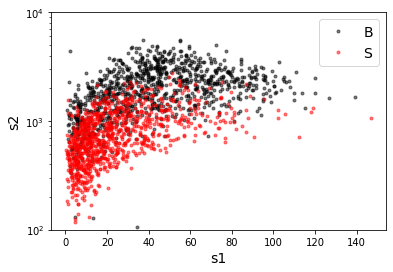

B_pdiffT.shape:  (5000,)
S_pdiffT.shape:  (5000,)


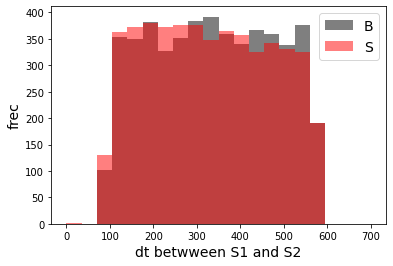

In [19]:

# CONCATENATE THE BACKGROUNDS
B_pbot = np.concatenate([B_pbot_ER[:NUM_DAT_ER], B_pbot_AC[:NUM_DAT_AC], B_pbot_CNNS[:NUM_DAT_CNNS], B_pbot_RN[:NUM_DAT_RN], B_pbot_WALL[:NUM_DAT_WALL]])
B_ptop = np.concatenate([B_ptop_ER[:NUM_DAT_ER], B_ptop_AC[:NUM_DAT_AC], B_ptop_CNNS[:NUM_DAT_CNNS], B_ptop_RN[:NUM_DAT_RN], B_ptop_WALL[:NUM_DAT_WALL]])
B_ppeakS1 = np.concatenate([B_ppeakS1_ER[:NUM_DAT_ER], B_ppeakS1_AC[:NUM_DAT_AC], B_ppeakS1_CNNS[:NUM_DAT_CNNS], B_ppeakS1_RN[:NUM_DAT_RN], B_ppeakS1_WALL[:NUM_DAT_WALL]])
B_ppeakS2 = np.concatenate([B_ppeakS2_ER[:NUM_DAT_ER], B_ppeakS2_AC[:NUM_DAT_AC], B_ppeakS2_CNNS[:NUM_DAT_CNNS], B_ppeakS2_RN[:NUM_DAT_RN], B_ppeakS2_WALL[:NUM_DAT_WALL]])

print('\nB_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot[:num_data]
S_ptop = S_ptop[:num_data]
S_ppeakS1 = S_ppeakS1[:num_data]
S_ppeakS2 = S_ppeakS2[:num_data]

print('\nS_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


rnd = 100

B_pbot_plot, B_ptop_plot = shuffle(B_pbot, B_ptop, random_state=rnd)
S_pbot_plot, S_ptop_plot = shuffle(S_pbot, S_ptop, random_state=rnd)

plt.plot(B_pbot_plot[:1000], B_ptop_plot[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_pbot_plot[:1000], S_ptop_plot[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2',fontsize=14)
plt.legend(fontsize=14)
plt.show()



# CONSTRUCT THE TIME DIFFERENCE BETWEEN PULSES

B_pdiffT = B_ppeakS2[:,0] - B_ppeakS1[:,0]
S_pdiffT = S_ppeakS2[:,0] - S_ppeakS1[:,0]

print('B_pdiffT.shape: ', B_pdiffT.shape)
print('S_pdiffT.shape: ', S_pdiffT.shape)


plt.hist(B_pdiffT, range=[0,700], bins=20, color='black', alpha=0.5, label='B')
plt.hist(S_pdiffT, range=[0,700], bins=20, color='red', alpha=0.5, label='S')
# plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('dt betwween S1 and S2',fontsize=14)
plt.ylabel('frec',fontsize=14)
plt.legend(fontsize=14)
plt.show()

##### Remove the absolute times of each pulse (we just need the time difference between pulses
other variables also can be removed if you want

In [20]:
remove_col = [0] # index = 0 is pT0

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (5000,)
B_ptop.shape:  (5000,)
B_ppeakS1.shape : (5000, 7)
B_ppeakS2.shape:  (5000, 7)
S_pbot.shape:  (5000,)
S_ptop.shape:  (5000,)
S_ppeakS1.shape : (5000, 7)
S_ppeakS2.shape:  (5000, 7)


## 1. No compressed features

In [21]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val],axis=1)



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val



print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (4999, 35244)
y_mon_train :  (4999,)
X_mon_val :  (1667, 35244)
y_mon_val :  (1667,)
X_mon_test :  (3334, 35244)
y_mon_test :  (3334,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.63782	validation_1-logloss:0.64597
[1]	validation_0-logloss:0.59264	validation_1-logloss:0.60957
[2]	validation_0-logloss:0.55368	validation_1-logloss:0.57729
[3]	validation_0-logloss:0.51935	validation_1-logloss:0.54905
[4]	validation_0-logloss:0.48994	validation_1-logloss:0.52651
[5]	validation_0-logloss:0.46297	validation_1-logloss:0.50599
[6]	validation_0-logloss:0.43958	validation_1-logloss:0.48782
[7]	validation_0-logloss:0.41803	validation_1-logloss:0.47130
[8]	validation_0-logloss:0.39836	validation_1-logloss:0.45885
[9]	validation_0-logloss:0.38007	validation_1-logloss:0.44504
[10]	validation_0-logloss:0.36274	validation_1-logloss:0.43352
[11]	validation_0-logloss:0.34715	validation_1-logloss:0.42306
[12]	validation_0-logloss:0.33436	validation_1-logloss:0.41520
[13]	validation_0-logloss:0.32049	validation_1-logloss:0.40555
[14]	validation_0-logloss:0.30845	validation_1-logloss:0.39905
[15]	validation_0-logloss:0.29741	validation_1-logloss:0.39420
[1

[130]	validation_0-logloss:0.04106	validation_1-logloss:0.29706
[131]	validation_0-logloss:0.04082	validation_1-logloss:0.29686
[132]	validation_0-logloss:0.04058	validation_1-logloss:0.29662
[133]	validation_0-logloss:0.04017	validation_1-logloss:0.29686
[134]	validation_0-logloss:0.03965	validation_1-logloss:0.29665
[135]	validation_0-logloss:0.03911	validation_1-logloss:0.29633
[136]	validation_0-logloss:0.03887	validation_1-logloss:0.29682
[137]	validation_0-logloss:0.03859	validation_1-logloss:0.29678
[138]	validation_0-logloss:0.03833	validation_1-logloss:0.29713
[139]	validation_0-logloss:0.03784	validation_1-logloss:0.29676
[140]	validation_0-logloss:0.03726	validation_1-logloss:0.29718
[141]	validation_0-logloss:0.03659	validation_1-logloss:0.29783
[142]	validation_0-logloss:0.03636	validation_1-logloss:0.29803
[143]	validation_0-logloss:0.03600	validation_1-logloss:0.29764
[144]	validation_0-logloss:0.03577	validation_1-logloss:0.29793
[145]	validation_0-logloss:0.03549	valid

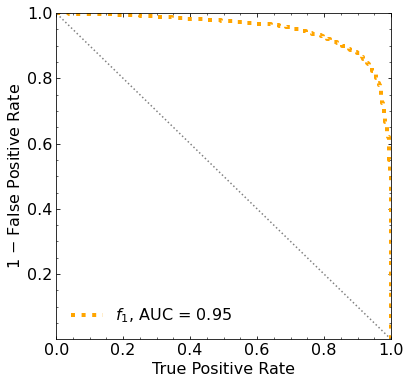

Classification score:


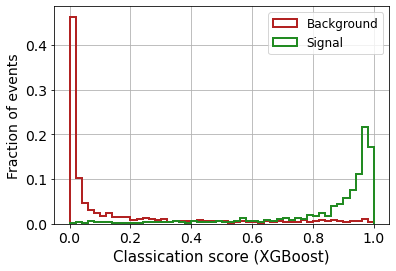


 ROC-AUC =  0.9512969249862503


In [22]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [23]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9512969249862503


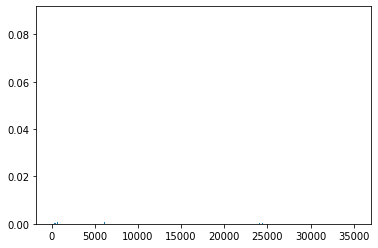

In [24]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

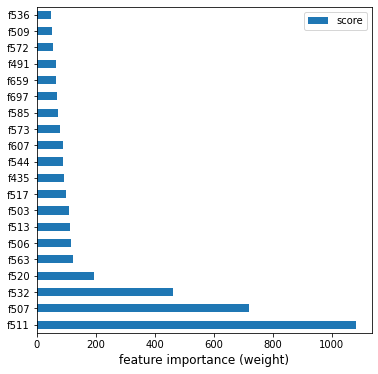

In [25]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### DNN

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 32)                1127840   
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_26 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_27 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                

Epoch 50/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5935 - accuracy: 0.7027 - val_loss: 0.4991 - val_accuracy: 0.8074
Epoch 51/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5459 - accuracy: 0.7513 - val_loss: 0.4669 - val_accuracy: 0.8284
Epoch 52/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5410 - accuracy: 0.7612 - val_loss: 0.4801 - val_accuracy: 0.8218
Epoch 53/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5274 - accuracy: 0.7658 - val_loss: 0.4639 - val_accuracy: 0.8278
Epoch 54/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5431 - accuracy: 0.7601 - val_loss: 0.4650 - val_accuracy: 0.8272
Epoch 55/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5411 - accuracy: 0.7629 - val_loss: 0.4629 - val_accuracy: 0.8272
Epoch 56/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5411 - accuracy: 0.7715 - val_loss: 0.4694 - val_accuracy: 0.8170
Epoch 

40/40 [==============================] - 0s 8ms/step - loss: 0.4937 - accuracy: 0.7838 - val_loss: 0.4685 - val_accuracy: 0.8200
Epoch 108/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4837 - accuracy: 0.7894 - val_loss: 0.4759 - val_accuracy: 0.8134
Epoch 109/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4823 - accuracy: 0.7990 - val_loss: 0.4320 - val_accuracy: 0.8284
Epoch 110/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5116 - accuracy: 0.7721 - val_loss: 0.4557 - val_accuracy: 0.8272
Epoch 111/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4902 - accuracy: 0.7883 - val_loss: 0.4229 - val_accuracy: 0.8434
Epoch 112/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4920 - accuracy: 0.7881 - val_loss: 0.4371 - val_accuracy: 0.8392
Epoch 113/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5166 - accuracy: 0.7702 - val_loss: 0.4242 - val_accuracy: 0.8404
Epoch 114/500

40/40 [==============================] - 0s 8ms/step - loss: 0.4762 - accuracy: 0.8008 - val_loss: 0.4673 - val_accuracy: 0.8236
Epoch 165/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4766 - accuracy: 0.7961 - val_loss: 0.4437 - val_accuracy: 0.8458
Epoch 166/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4903 - accuracy: 0.7913 - val_loss: 0.6068 - val_accuracy: 0.6773
Epoch 167/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5166 - accuracy: 0.7697 - val_loss: 0.4323 - val_accuracy: 0.8422
Epoch 168/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4850 - accuracy: 0.7907 - val_loss: 0.4273 - val_accuracy: 0.8410
Epoch 169/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4737 - accuracy: 0.8023 - val_loss: 0.4319 - val_accuracy: 0.8464
Epoch 170/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4715 - accuracy: 0.7992 - val_loss: 0.4904 - val_accuracy: 0.8008
Epoch 171/500

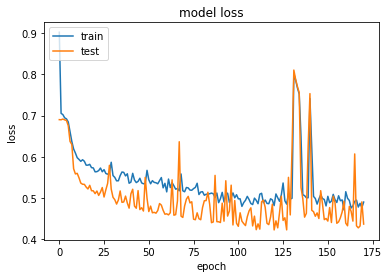

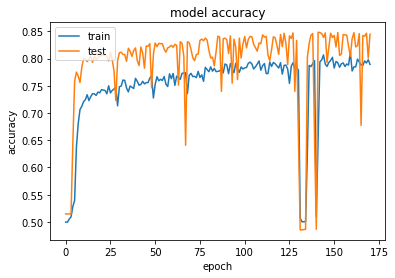

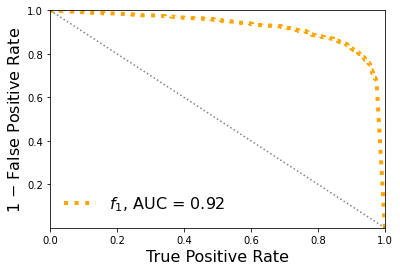

Classification score:


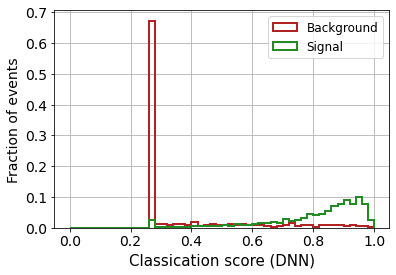


 ROC-AUC =  0.9206234540705995


In [44]:

# define the keras model
model = Sequential()
model.add(Dense(32, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [45]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9206234540705995


### CNN

In [46]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
40/40 [==============================] - 23s 549ms/step - loss: 1.9601 - accuracy: 0.6111 - val_loss: 0.5708 - val_accuracy: 0.7433
Epoch 2/500
40/40 [==============================] - 22s 555ms/step - loss: 0.5926 - accuracy: 0.7239 - val_loss: 0.5482 - val_accuracy: 0.7546
Epoch 3/500
40/40 [==============================] - 22s 560ms/step - loss: 0.5545 - accuracy: 0.7523 - val_loss: 0.5230 - val_accuracy: 0.7451
Epoch 4/500
40/40 [==============================] - 22s 553ms/step - loss: 0.5202 - accuracy: 0.7796 - val_loss: 0.4906 - val_accuracy: 0.7858
Epoch 5/500
40/40 [==============================] - 21s 538ms/step - loss: 0.5263 - accuracy: 0.7662 - val_loss: 0.4671 - val_accuracy: 0.7978
Epoch 6/500
40/40 [==============================] - 22s 544ms/step - loss: 0.5100 - accuracy: 0.7771 - val_loss: 0.4745 - val_accuracy: 0.7930
Epoch 7/500
40/40 [==============================] - 22s 542ms/step - loss: 0.4994 - accuracy: 0.7475 - val_loss: 0.4516 - val_accuracy:

40/40 [==============================] - 23s 572ms/step - loss: 0.7105 - accuracy: 0.4962 - val_loss: 0.7058 - val_accuracy: 0.5147
Epoch 58/500
40/40 [==============================] - 22s 557ms/step - loss: 0.7070 - accuracy: 0.5079 - val_loss: 0.7052 - val_accuracy: 0.5147
Epoch 59/500
40/40 [==============================] - 22s 562ms/step - loss: 0.7081 - accuracy: 0.4975 - val_loss: 0.7045 - val_accuracy: 0.5147
Epoch 60/500
40/40 [==============================] - 23s 569ms/step - loss: 0.7055 - accuracy: 0.5071 - val_loss: 0.7040 - val_accuracy: 0.5147
Epoch 61/500
40/40 [==============================] - 23s 578ms/step - loss: 0.7042 - accuracy: 0.5121 - val_loss: 0.7036 - val_accuracy: 0.5147
Epoch 62/500
40/40 [==============================] - 23s 563ms/step - loss: 0.7059 - accuracy: 0.4966 - val_loss: 0.7032 - val_accuracy: 0.5147
Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping


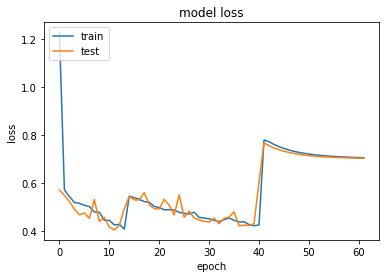

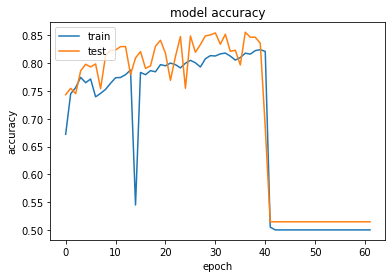

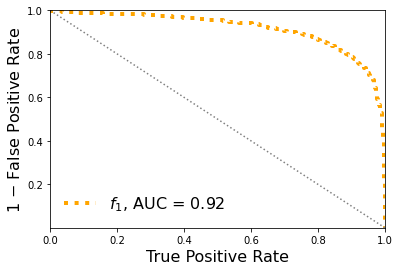

Classification score:


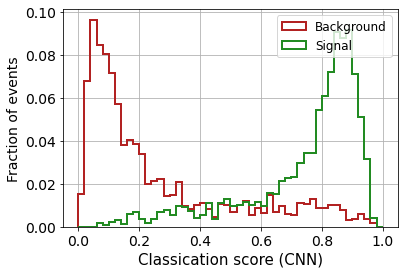


 ROC-AUC =  0.9158672465971558


In [48]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [49]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9158672465971558


## 2. only time diff

In [51]:
# concatenate the data

# all the background features
X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))

# all the signal features
X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')



X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)



# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)



X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)



print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (5000, 1)
X_mon_S.shape:  (5000, 1)

X_mon5.shape:  (10000, 1)

X_mon5_train :  (4999, 1)
y_mon5_train :  (4999,)
X_mon5_val :  (1667, 1)
y_mon5_val :  (1667,)
X_mon5_test :  (3334, 1)
y_mon5_test :  (3334,)



In [52]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val],axis=1)



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val



print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (4999, 35245)
y_mon_train :  (4999,)
X_mon_val :  (1667, 35245)
y_mon_val :  (1667,)
X_mon_test :  (3334, 35245)
y_mon_test :  (3334,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.63777	validation_1-logloss:0.64653
[1]	validation_0-logloss:0.59256	validation_1-logloss:0.60984
[2]	validation_0-logloss:0.55262	validation_1-logloss:0.57790
[3]	validation_0-logloss:0.51810	validation_1-logloss:0.55070
[4]	validation_0-logloss:0.48743	validation_1-logloss:0.52711
[5]	validation_0-logloss:0.46122	validation_1-logloss:0.50560
[6]	validation_0-logloss:0.43746	validation_1-logloss:0.48782
[7]	validation_0-logloss:0.41503	validation_1-logloss:0.46993
[8]	validation_0-logloss:0.39555	validation_1-logloss:0.45542
[9]	validation_0-logloss:0.37700	validation_1-logloss:0.44119
[10]	validation_0-logloss:0.36059	validation_1-logloss:0.42946
[11]	validation_0-logloss:0.34495	validation_1-logloss:0.41929
[12]	validation_0-logloss:0.33076	validation_1-logloss:0.40937
[13]	validation_0-logloss:0.31765	validation_1-logloss:0.40026
[14]	validation_0-logloss:0.30487	validation_1-logloss:0.39215
[15]	validation_0-logloss:0.29393	validation_1-logloss:0.38601
[1

[130]	validation_0-logloss:0.02349	validation_1-logloss:0.24988
[131]	validation_0-logloss:0.02324	validation_1-logloss:0.24947
[132]	validation_0-logloss:0.02300	validation_1-logloss:0.24923
[133]	validation_0-logloss:0.02275	validation_1-logloss:0.24968
[134]	validation_0-logloss:0.02242	validation_1-logloss:0.24973
[135]	validation_0-logloss:0.02216	validation_1-logloss:0.24937
[136]	validation_0-logloss:0.02178	validation_1-logloss:0.24951
[137]	validation_0-logloss:0.02144	validation_1-logloss:0.24930
[138]	validation_0-logloss:0.02128	validation_1-logloss:0.24939
[139]	validation_0-logloss:0.02109	validation_1-logloss:0.24923
[140]	validation_0-logloss:0.02083	validation_1-logloss:0.24924
[141]	validation_0-logloss:0.02057	validation_1-logloss:0.24985
[142]	validation_0-logloss:0.02025	validation_1-logloss:0.24968
[143]	validation_0-logloss:0.02009	validation_1-logloss:0.25011
[144]	validation_0-logloss:0.01975	validation_1-logloss:0.25003
[145]	validation_0-logloss:0.01949	valid

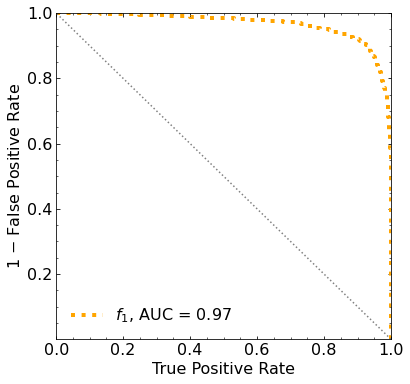

Classification score:


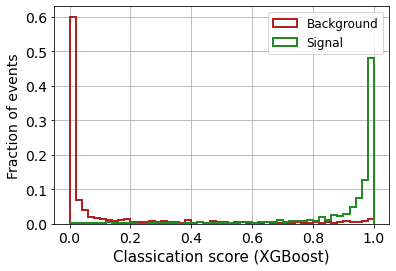


 ROC-AUC =  0.9667900530691107


In [53]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [54]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9667900530691107


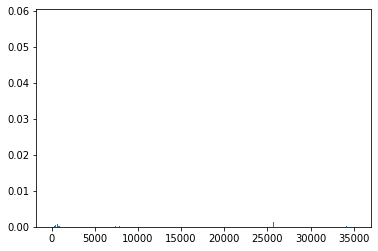

In [55]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

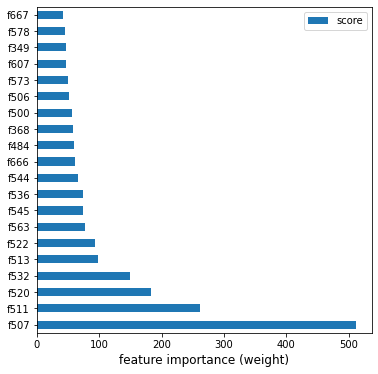


f35245: pdiffT


In [56]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()



print('\nf'+ str(len(classifier.feature_importances_)) + ': pdiffT')

### DNN

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 32)                1127872   
_________________________________________________________________
dropout_37 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_38 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_39 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)               

Epoch 50/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4270 - accuracy: 0.7588 - val_loss: 0.4058 - val_accuracy: 0.8236
Epoch 51/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4348 - accuracy: 0.7567 - val_loss: 0.3687 - val_accuracy: 0.8512
Epoch 52/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4526 - accuracy: 0.7440 - val_loss: 0.3887 - val_accuracy: 0.8290
Epoch 53/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4610 - accuracy: 0.7163 - val_loss: 0.3371 - val_accuracy: 0.8740
Epoch 54/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4325 - accuracy: 0.7608 - val_loss: 0.5219 - val_accuracy: 0.7211
Epoch 55/500
40/40 [==============================] - 0s 8ms/step - loss: 0.6892 - accuracy: 0.6036 - val_loss: 0.5325 - val_accuracy: 0.8692
Epoch 56/500
40/40 [==============================] - 0s 8ms/step - loss: 0.5580 - accuracy: 0.7215 - val_loss: 0.5108 - val_accuracy: 0.8428
Epoch 

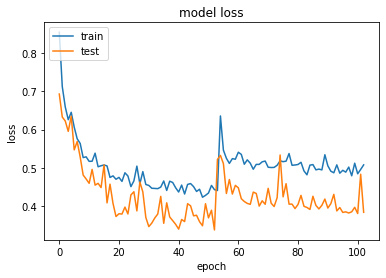

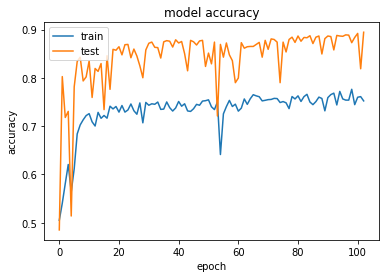

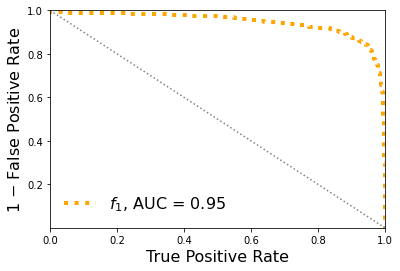

Classification score:


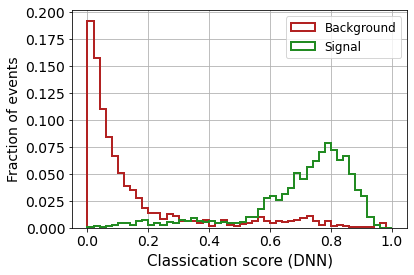


 ROC-AUC =  0.9459543801452993


In [62]:

# define the keras model
model = Sequential()
model.add(Dense(32, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [63]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9459543801452993


### CNN

In [64]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
40/40 [==============================] - 20s 494ms/step - loss: 3.0431 - accuracy: 0.5694 - val_loss: 0.5238 - val_accuracy: 0.7798
Epoch 2/500
40/40 [==============================] - 19s 488ms/step - loss: 0.5505 - accuracy: 0.6974 - val_loss: 0.4660 - val_accuracy: 0.8062
Epoch 3/500
40/40 [==============================] - 19s 483ms/step - loss: 0.4876 - accuracy: 0.7481 - val_loss: 0.4328 - val_accuracy: 0.8212
Epoch 4/500
40/40 [==============================] - 19s 485ms/step - loss: 0.4809 - accuracy: 0.7552 - val_loss: 0.4372 - val_accuracy: 0.8350
Epoch 5/500
40/40 [==============================] - 19s 486ms/step - loss: 0.4630 - accuracy: 0.7601 - val_loss: 0.4190 - val_accuracy: 0.8422
Epoch 6/500
40/40 [==============================] - 19s 482ms/step - loss: 0.4580 - accuracy: 0.7637 - val_loss: 0.3976 - val_accuracy: 0.8446
Epoch 7/500
40/40 [==============================] - 19s 483ms/step - loss: 0.4329 - accuracy: 0.7835 - val_loss: 0.3822 - val_accuracy:

40/40 [==============================] - 19s 483ms/step - loss: 0.3708 - accuracy: 0.8480 - val_loss: 0.3403 - val_accuracy: 0.8812
Epoch 58/500
40/40 [==============================] - 19s 480ms/step - loss: 0.3712 - accuracy: 0.8481 - val_loss: 0.3367 - val_accuracy: 0.8842
Epoch 59/500
40/40 [==============================] - 19s 481ms/step - loss: 0.3671 - accuracy: 0.8480 - val_loss: 0.3360 - val_accuracy: 0.8824
Epoch 60/500
40/40 [==============================] - 19s 477ms/step - loss: 0.3638 - accuracy: 0.8550 - val_loss: 0.3469 - val_accuracy: 0.8788
Epoch 61/500
40/40 [==============================] - 19s 471ms/step - loss: 0.3530 - accuracy: 0.8583 - val_loss: 0.3589 - val_accuracy: 0.8704
Epoch 62/500
40/40 [==============================] - 19s 474ms/step - loss: 0.3684 - accuracy: 0.8493 - val_loss: 0.3295 - val_accuracy: 0.8890
Epoch 63/500
40/40 [==============================] - 19s 472ms/step - loss: 0.3598 - accuracy: 0.8508 - val_loss: 0.3324 - val_accuracy: 0.886

40/40 [==============================] - 25s 630ms/step - loss: 0.3275 - accuracy: 0.8718 - val_loss: 0.6268 - val_accuracy: 0.8230
Epoch 114/500
40/40 [==============================] - 20s 498ms/step - loss: 0.4368 - accuracy: 0.8055 - val_loss: 0.5172 - val_accuracy: 0.7534
Epoch 115/500
40/40 [==============================] - 22s 549ms/step - loss: 0.4338 - accuracy: 0.8053 - val_loss: 0.3684 - val_accuracy: 0.8626
Restoring model weights from the end of the best epoch.
Epoch 00115: early stopping


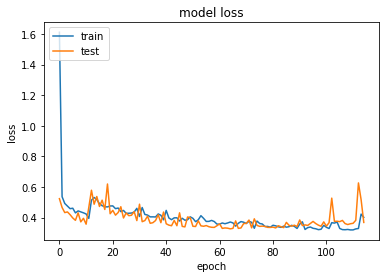

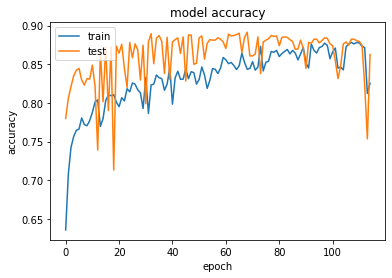

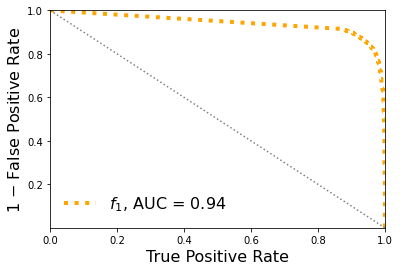

Classification score:


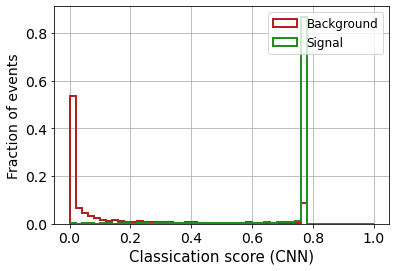


 ROC-AUC =  0.9411128676036546


In [77]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
#model.add(Conv1D(4, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
#model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [78]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9411128676036546


## 3. All compressed features

In [79]:
# concatenate the data

# all the background features
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)

# all the signal features
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')

del B_ppeakS1
del B_ppeakS2
del B_pbot
del B_ptop

del S_ppeakS1
del S_ppeakS2
del S_pbot
del S_ptop


X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)
del X_mon_B
del X_mon_S


# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)

del X_mon5
del y_mon5

X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)

del X_mon5_aux
del y_mon5_aux

print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (5000, 17)
X_mon_S.shape:  (5000, 17)

X_mon5.shape:  (10000, 17)

X_mon5_train :  (4999, 17)
y_mon5_train :  (4999,)
X_mon5_val :  (1667, 17)
y_mon5_val :  (1667,)
X_mon5_test :  (3334, 17)
y_mon5_test :  (3334,)



##### Concatenate into one single big dataset

In [80]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val],axis=1)

del X_mon1_train
del X_mon2_train
del X_mon3_train
del X_mon4_train
del X_mon5_train

del X_mon1_test
del X_mon2_test
del X_mon3_test
del X_mon4_test
del X_mon5_test

del X_mon1_val
del X_mon2_val
del X_mon3_val
del X_mon4_val
del X_mon5_val



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val

del y_mon1_train
del y_mon2_train
del y_mon3_train
del y_mon4_train
del y_mon5_train

del y_mon1_test
del y_mon2_test
del y_mon3_test
del y_mon4_test
del y_mon5_test

del y_mon1_val
del y_mon2_val
del y_mon3_val
del y_mon4_val
del y_mon5_val


In [81]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (4999, 35261)
y_mon_train :  (4999,)
X_mon_val :  (1667, 35261)
y_mon_val :  (1667,)
X_mon_test :  (3334, 35261)
y_mon_test :  (3334,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.62842	validation_1-logloss:0.63493
[1]	validation_0-logloss:0.57437	validation_1-logloss:0.58715
[2]	validation_0-logloss:0.52820	validation_1-logloss:0.54572
[3]	validation_0-logloss:0.49002	validation_1-logloss:0.51259
[4]	validation_0-logloss:0.45339	validation_1-logloss:0.47922
[5]	validation_0-logloss:0.42313	validation_1-logloss:0.45319
[6]	validation_0-logloss:0.39776	validation_1-logloss:0.43208
[7]	validation_0-logloss:0.37243	validation_1-logloss:0.41044
[8]	validation_0-logloss:0.35012	validation_1-logloss:0.39125
[9]	validation_0-logloss:0.33028	validation_1-logloss:0.37500
[10]	validation_0-logloss:0.31303	validation_1-logloss:0.36190
[11]	validation_0-logloss:0.29719	validation_1-logloss:0.34964
[12]	validation_0-logloss:0.28195	validation_1-logloss:0.33647
[13]	validation_0-logloss:0.27004	validation_1-logloss:0.32778
[14]	validation_0-logloss:0.25813	validation_1-logloss:0.31936
[15]	validation_0-logloss:0.24576	validation_1-logloss:0.31010
[1

[130]	validation_0-logloss:0.02458	validation_1-logloss:0.22381
[131]	validation_0-logloss:0.02442	validation_1-logloss:0.22379
[132]	validation_0-logloss:0.02393	validation_1-logloss:0.22408
[133]	validation_0-logloss:0.02339	validation_1-logloss:0.22375
[134]	validation_0-logloss:0.02309	validation_1-logloss:0.22376
[135]	validation_0-logloss:0.02274	validation_1-logloss:0.22395
[136]	validation_0-logloss:0.02245	validation_1-logloss:0.22414
[137]	validation_0-logloss:0.02205	validation_1-logloss:0.22426
[138]	validation_0-logloss:0.02182	validation_1-logloss:0.22456
[139]	validation_0-logloss:0.02152	validation_1-logloss:0.22429
[140]	validation_0-logloss:0.02127	validation_1-logloss:0.22418
[141]	validation_0-logloss:0.02097	validation_1-logloss:0.22421
[142]	validation_0-logloss:0.02084	validation_1-logloss:0.22433
[143]	validation_0-logloss:0.02056	validation_1-logloss:0.22493
[144]	validation_0-logloss:0.02026	validation_1-logloss:0.22483
[145]	validation_0-logloss:0.02000	valid

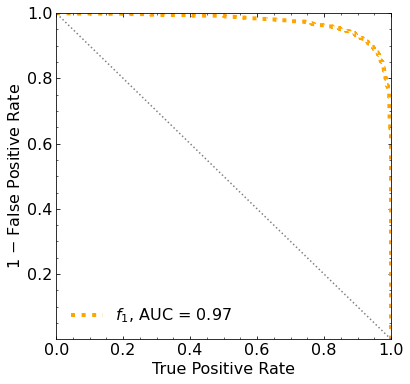

Classification score:


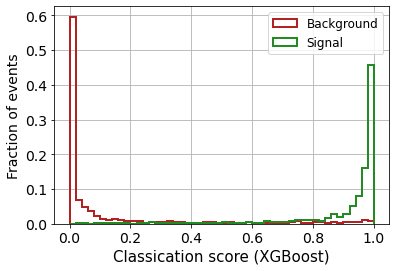


 ROC-AUC =  0.9736509921303376


In [82]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [83]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9736509921303376


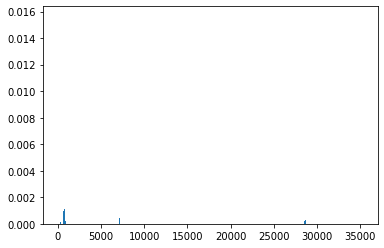

In [84]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

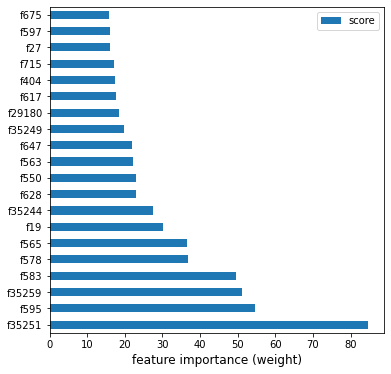


peakS1:     147 features  --> f0 to f146
peakS2:    2298 features  --> f147 to f2444
hits bot: 16384 features  --> f2445 to f18828
hits top: 16384 features  --> f18829 to f35212
resumed:     17 features  --> f35213 to f35229

f35213: pA_S1 
f35214: pH_S1 
f35215: pHT_S1 
f35216: pL_S1 
f35217: pL90_S1 
f35218: pRMSW_S1 
f35219: pHTL_S1 
f35220: pA_S2 
f35221: pH_S2 
f35222: pHT_S2 
f35223: pL_S2 
f35224: pL90_S2 
f35225: pRMSW_S2 
f35226: pHTL_S2 
f35227: pbot 
f35228: ptop 
f35229: pdiffT


In [85]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

print('\npeakS1:     147 features  --> f0 to f146')
print('peakS2:    2298 features  --> f147 to f2444')
print('hits bot: 16384 features  --> f2445 to f18828')
print('hits top: 16384 features  --> f18829 to f35212')
print('resumed:     17 features  --> f35213 to f35229')

print('\nf35213: pA_S1',
      '\nf35214: pH_S1',
      '\nf35215: pHT_S1',
      '\nf35216: pL_S1',
      '\nf35217: pL90_S1',
      '\nf35218: pRMSW_S1',
      '\nf35219: pHTL_S1',
      '\nf35220: pA_S2',
      '\nf35221: pH_S2',
      '\nf35222: pHT_S2',
      '\nf35223: pL_S2',
      '\nf35224: pL90_S2',
      '\nf35225: pRMSW_S2',
      '\nf35226: pHTL_S2',
      '\nf35227: pbot', 
      '\nf35228: ptop',
      '\nf35229: pdiffT')

In [86]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, B_expected, range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  14 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  14
range of our data:  [[0, 1]]


In [87]:
num_bins = 10

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0685


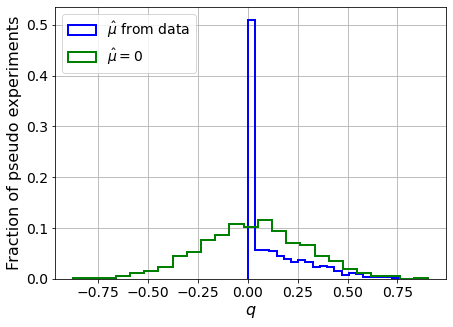

muhat mean:  -0.029209354072321222
Z_bins:  0.17434080996738952
std Z_bins:  0.46908313097629983
Z_bins mu=0:  0.17434080996738952
std Z_bins mu=0:  0.7547948406596159

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0685


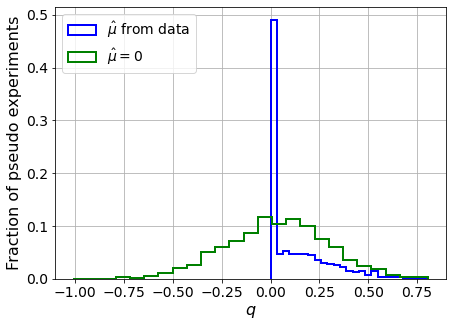

muhat mean:  -0.11063294097863699
Z_bins:  0.20274827326715789
std Z_bins:  0.3981686589945996
Z_bins mu=0:  0.20274827326715789
std Z_bins mu=0:  0.6467812489852498

--------

B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.069


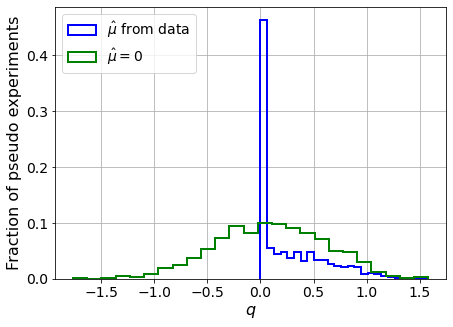

muhat mean:  0.05529550777720476
Z_bins:  0.3104384346207664
std Z_bins:  0.5225213964985918
Z_bins mu=0:  0.3098420269696501
std Z_bins mu=0:  0.8338156398035206

--------

B_expected:  643
S_expected:  3

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0775


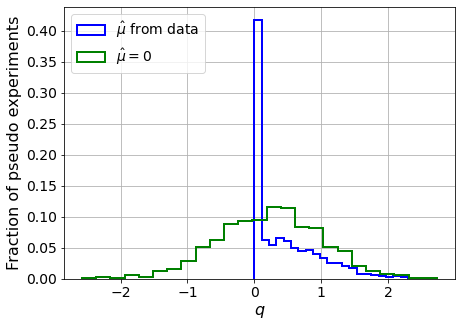

muhat mean:  0.00970200570700968
Z_bins:  0.5077899019945027
std Z_bins:  0.5025929247253949
Z_bins mu=0:  0.5077899019945027
std Z_bins mu=0:  0.7555361986605091

--------

B_expected:  643
S_expected:  7

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0635


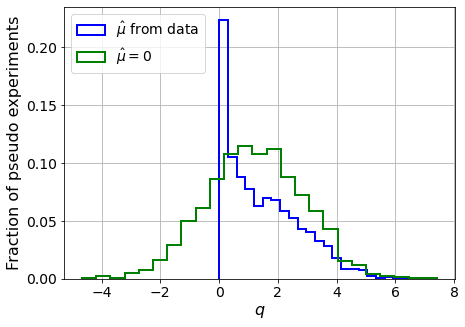

muhat mean:  -0.02043157335992853
Z_bins:  1.1014543609963658
std Z_bins:  0.5888976704868756
Z_bins mu=0:  1.1014543609963658
std Z_bins mu=0:  0.7522516665284406

--------

B_expected:  643
S_expected:  15

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.07


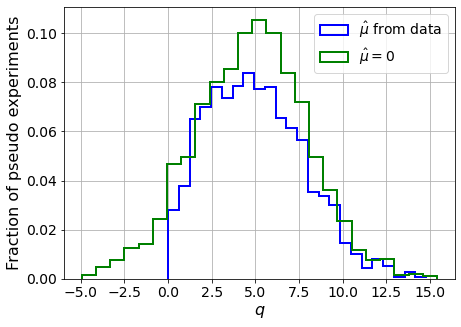

muhat mean:  -0.0030762260034335846
Z_bins:  2.2009816003959184
std Z_bins:  0.6288390334744329
Z_bins mu=0:  2.2009816003959184
std Z_bins mu=0:  0.7248927226638228

--------

B_expected:  643
S_expected:  33

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.065


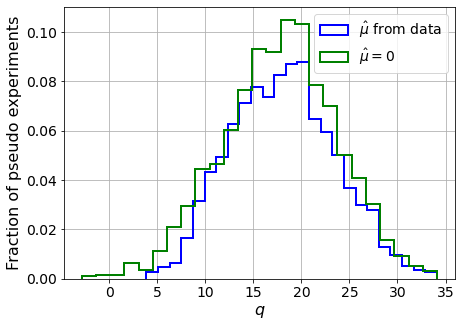

muhat mean:  0.004171578963741483
Z_bins:  4.247471116025427
std Z_bins:  0.6380060819919878
Z_bins mu=0:  4.247396614861593
std Z_bins mu=0:  0.6969453370563004

--------

B_expected:  643
S_expected:  72

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0675


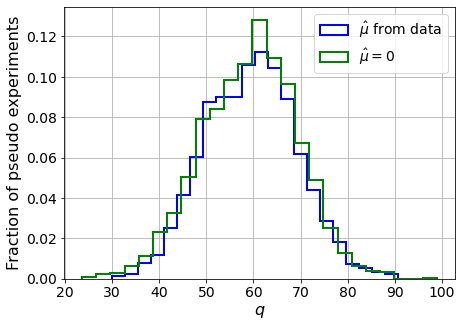

muhat mean:  0.00021966192328162537
Z_bins:  7.732424773346681
std Z_bins:  0.6248016871501694
Z_bins mu=0:  7.732424773346681
std Z_bins mu=0:  0.657305840731021

--------

B_expected:  643
S_expected:  154

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0675


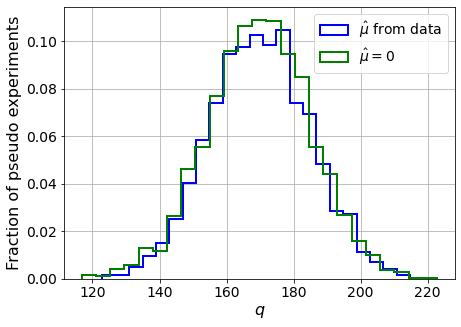

muhat mean:  0.0005505706302011264
Z_bins:  13.0391803905806
std Z_bins:  0.5692955975305594
Z_bins mu=0:  13.039007831086133
std Z_bins mu=0:  0.5886842125511887

--------

B_expected:  643
S_expected:  332

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0665


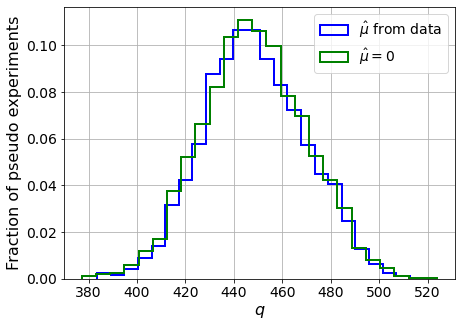

muhat mean:  0.00013005380555422365
Z_bins:  21.16422833325424
std Z_bins:  0.4973711285380743
Z_bins mu=0:  21.16422833325424
std Z_bins mu=0:  0.5078633941913254

--------


 FINAL RESULT:

[[0.17434080996738952, 0.46908313097629983, -0.029209354072321222, 0.17434080996738952, 0.7547948406596159], [0.20274827326715789, 0.3981686589945996, -0.11063294097863699, 0.20274827326715789, 0.6467812489852498], [0.3104384346207664, 0.5225213964985918, 0.05529550777720476, 0.3098420269696501, 0.8338156398035206], [0.5077899019945027, 0.5025929247253949, 0.00970200570700968, 0.5077899019945027, 0.7555361986605091], [1.1014543609963658, 0.5888976704868756, -0.02043157335992853, 1.1014543609963658, 0.7522516665284406], [2.2009816003959184, 0.6288390334744329, -0.0030762260034335846, 2.2009816003959184, 0.7248927226638228], [4.247471116025427, 0.6380060819919878, 0.004171578963741483, 4.247396614861593, 0.6969453370563004], [7.732424773346681, 0.6248016871501694, 0.00021966192328162537, 7.732424773

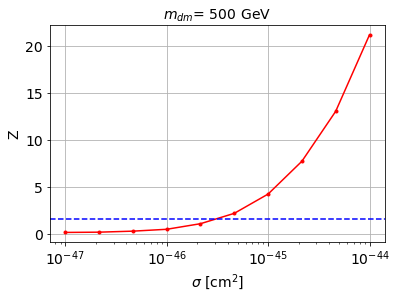


cross_BL_164:  3.1376113712473207e-46
cross_BL_164_up:  2.0354003605650286e-46
cross_BL_164_down:  4.761777017581049e-46


In [88]:
# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []


for s_it in range(len(S_expected)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[s_it])
    print('')

    Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, S_expected[s_it], num_pseudo, num_bins, range_dat, MIN_EVS, linear_bins=True) 
    
    store_Z_BL.append( list(Z_BL) )
    
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=0: ', Z_BL[3])
    print('std Z_bins mu=0: ', Z_BL[4])
    print('')
    print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)


# plot
plt.plot(cross_factor*1e-45, np.array(store_Z_BL)[:,0], '.-', c='red')

plt.axhline(y=1.64, c='blue', linestyle='--')
plt.title('$m_{dm}$= %0.2d GeV' % mDM, fontsize=14)
plt.xscale('log')
plt.xlabel(r'$\sigma$ [cm$^2$]', fontsize=14)
plt.ylabel(r'Z', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()


# interpolate
f_Z = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0], kind='linear')
f_Z_up = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] + np.array(store_Z_BL)[:,1], kind='linear')
f_Z_down = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] - np.array(store_Z_BL)[:,1], kind='linear')

# compute the cross section with Z=1.64
cross_BL_164 = 10**solvecross(f_Z, 1.64)
cross_BL_164_up = 10**solvecross(f_Z_up, 1.64)
cross_BL_164_down = 10**solvecross(f_Z_down, 1.64)

print('\ncross_BL_164: ', cross_BL_164)
print('cross_BL_164_up: ', cross_BL_164_up)
print('cross_BL_164_down: ', cross_BL_164_down)

### DNN

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 32)                1128384   
_________________________________________________________________
dropout_53 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_54 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_55 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_85 (Dense)             (None, 1)               

Epoch 50/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4705 - accuracy: 0.7820 - val_loss: 0.3548 - val_accuracy: 0.8692
Epoch 51/500
40/40 [==============================] - 0s 8ms/step - loss: 0.4521 - accuracy: 0.7906 - val_loss: 0.3171 - val_accuracy: 0.8914
Epoch 52/500
40/40 [==============================] - 0s 8ms/step - loss: 0.3660 - accuracy: 0.8550 - val_loss: 0.3487 - val_accuracy: 0.8674
Epoch 53/500
40/40 [==============================] - 0s 8ms/step - loss: 0.3971 - accuracy: 0.8368 - val_loss: 0.3314 - val_accuracy: 0.8770
Epoch 54/500
40/40 [==============================] - 0s 8ms/step - loss: 0.3636 - accuracy: 0.8537 - val_loss: 0.3183 - val_accuracy: 0.8818
Epoch 55/500
40/40 [==============================] - 0s 8ms/step - loss: 0.3385 - accuracy: 0.8668 - val_loss: 0.2979 - val_accuracy: 0.8920
Epoch 56/500
40/40 [==============================] - 0s 8ms/step - loss: 0.3179 - accuracy: 0.8786 - val_loss: 0.3960 - val_accuracy: 0.8344
Epoch 

40/40 [==============================] - 0s 8ms/step - loss: 0.3165 - accuracy: 0.8816 - val_loss: 0.2924 - val_accuracy: 0.8950
Epoch 108/500
40/40 [==============================] - 0s 8ms/step - loss: 0.3048 - accuracy: 0.8797 - val_loss: 0.2877 - val_accuracy: 0.8908
Epoch 109/500
40/40 [==============================] - 0s 8ms/step - loss: 0.3028 - accuracy: 0.8816 - val_loss: 0.2975 - val_accuracy: 0.8866
Epoch 110/500
40/40 [==============================] - 0s 8ms/step - loss: 0.3117 - accuracy: 0.8809 - val_loss: 0.2897 - val_accuracy: 0.8962
Epoch 111/500
40/40 [==============================] - 0s 8ms/step - loss: 0.2915 - accuracy: 0.8917 - val_loss: 0.2883 - val_accuracy: 0.8944
Epoch 112/500
40/40 [==============================] - 0s 8ms/step - loss: 0.3069 - accuracy: 0.8853 - val_loss: 0.2896 - val_accuracy: 0.8956
Epoch 113/500
40/40 [==============================] - 0s 8ms/step - loss: 0.3230 - accuracy: 0.8752 - val_loss: 0.2819 - val_accuracy: 0.8932
Epoch 114/500

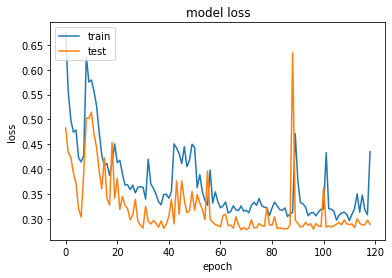

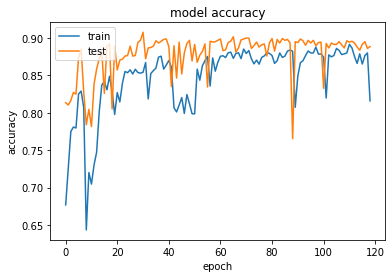

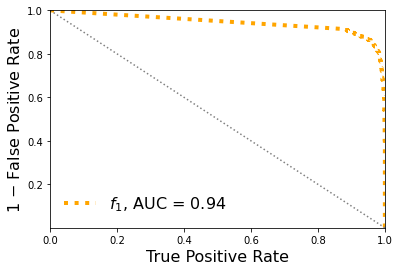

Classification score:


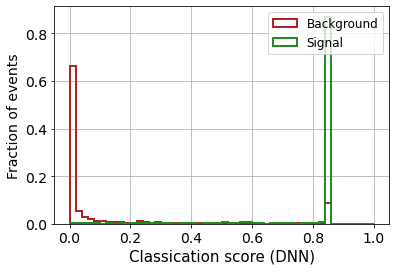


 ROC-AUC =  0.9439945231986593


In [89]:

# define the keras model
model = Sequential()
model.add(Dense(32, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [90]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9439945231986593


### CNN

In [91]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
40/40 [==============================] - 21s 509ms/step - loss: 1.4071 - accuracy: 0.4985 - val_loss: 0.7019 - val_accuracy: 0.5147
Epoch 2/500
40/40 [==============================] - 20s 505ms/step - loss: 0.7019 - accuracy: 0.4973 - val_loss: 0.7013 - val_accuracy: 0.5147
Epoch 3/500
40/40 [==============================] - 20s 504ms/step - loss: 0.7013 - accuracy: 0.5040 - val_loss: 0.7010 - val_accuracy: 0.5147
Epoch 4/500
40/40 [==============================] - 20s 505ms/step - loss: 0.7009 - accuracy: 0.5075 - val_loss: 0.7006 - val_accuracy: 0.5147
Epoch 5/500
40/40 [==============================] - 20s 505ms/step - loss: 0.7006 - accuracy: 0.4980 - val_loss: 0.7004 - val_accuracy: 0.5147
Epoch 6/500
40/40 [==============================] - 20s 506ms/step - loss: 0.7003 - accuracy: 0.4947 - val_loss: 0.7001 - val_accuracy: 0.5147
Epoch 7/500
40/40 [==============================] - 20s 511ms/step - loss: 0.7001 - accuracy: 0.5016 - val_loss: 0.7000 - val_accuracy:

40/40 [==============================] - 20s 501ms/step - loss: 0.6969 - accuracy: 0.5058 - val_loss: 0.6969 - val_accuracy: 0.4853
Epoch 58/500
40/40 [==============================] - 20s 502ms/step - loss: 0.6968 - accuracy: 0.4983 - val_loss: 0.6968 - val_accuracy: 0.4853
Epoch 59/500
40/40 [==============================] - 20s 502ms/step - loss: 0.6968 - accuracy: 0.4996 - val_loss: 0.6968 - val_accuracy: 0.4853
Epoch 60/500
40/40 [==============================] - 20s 501ms/step - loss: 0.6967 - accuracy: 0.4996 - val_loss: 0.6967 - val_accuracy: 0.4853
Epoch 61/500
40/40 [==============================] - 20s 501ms/step - loss: 0.6967 - accuracy: 0.4957 - val_loss: 0.6967 - val_accuracy: 0.4853
Epoch 62/500
40/40 [==============================] - 20s 502ms/step - loss: 0.6967 - accuracy: 0.4920 - val_loss: 0.6967 - val_accuracy: 0.4853
Epoch 63/500
40/40 [==============================] - 20s 502ms/step - loss: 0.6965 - accuracy: 0.5060 - val_loss: 0.6967 - val_accuracy: 0.485

40/40 [==============================] - 20s 502ms/step - loss: 0.6941 - accuracy: 0.4946 - val_loss: 0.6939 - val_accuracy: 0.5147
Epoch 114/500
40/40 [==============================] - 20s 501ms/step - loss: 0.6940 - accuracy: 0.4969 - val_loss: 0.6940 - val_accuracy: 0.5147
Epoch 115/500
40/40 [==============================] - 20s 502ms/step - loss: 0.6940 - accuracy: 0.5116 - val_loss: 0.6939 - val_accuracy: 0.5147
Epoch 116/500
40/40 [==============================] - 20s 502ms/step - loss: 0.6939 - accuracy: 0.5045 - val_loss: 0.6939 - val_accuracy: 0.4853
Epoch 117/500
40/40 [==============================] - 20s 502ms/step - loss: 0.6939 - accuracy: 0.4800 - val_loss: 0.6939 - val_accuracy: 0.4853
Epoch 118/500
40/40 [==============================] - 20s 501ms/step - loss: 0.6938 - accuracy: 0.5068 - val_loss: 0.6940 - val_accuracy: 0.4853
Epoch 119/500
40/40 [==============================] - 20s 502ms/step - loss: 0.6938 - accuracy: 0.5083 - val_loss: 0.6939 - val_accuracy:

40/40 [==============================] - 20s 502ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.5147
Epoch 170/500
40/40 [==============================] - 20s 501ms/step - loss: 0.6932 - accuracy: 0.4927 - val_loss: 0.6931 - val_accuracy: 0.5147
Epoch 171/500
40/40 [==============================] - 20s 502ms/step - loss: 0.6931 - accuracy: 0.5104 - val_loss: 0.6931 - val_accuracy: 0.5147
Epoch 172/500
40/40 [==============================] - 20s 502ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.5147
Epoch 173/500
40/40 [==============================] - 20s 502ms/step - loss: 0.6932 - accuracy: 0.4952 - val_loss: 0.6930 - val_accuracy: 0.5147
Epoch 174/500
40/40 [==============================] - 20s 502ms/step - loss: 0.6932 - accuracy: 0.4907 - val_loss: 0.6930 - val_accuracy: 0.5147
Epoch 175/500
40/40 [==============================] - 20s 501ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6931 - val_accuracy:

40/40 [==============================] - 20s 502ms/step - loss: 0.4148 - accuracy: 0.8189 - val_loss: 0.3500 - val_accuracy: 0.8728
Epoch 226/500
40/40 [==============================] - 20s 501ms/step - loss: 0.3909 - accuracy: 0.8343 - val_loss: 0.3455 - val_accuracy: 0.8740
Epoch 227/500
40/40 [==============================] - 20s 502ms/step - loss: 0.3847 - accuracy: 0.8433 - val_loss: 0.3346 - val_accuracy: 0.8818
Epoch 228/500
40/40 [==============================] - 20s 502ms/step - loss: 0.3984 - accuracy: 0.8256 - val_loss: 0.3898 - val_accuracy: 0.8452
Epoch 229/500
40/40 [==============================] - 20s 501ms/step - loss: 0.4456 - accuracy: 0.7942 - val_loss: 0.4146 - val_accuracy: 0.8236
Epoch 230/500
40/40 [==============================] - 20s 502ms/step - loss: 0.4728 - accuracy: 0.7745 - val_loss: 0.3329 - val_accuracy: 0.8800
Epoch 231/500
40/40 [==============================] - 20s 502ms/step - loss: 0.3881 - accuracy: 0.8369 - val_loss: 0.3334 - val_accuracy:

40/40 [==============================] - 20s 501ms/step - loss: 0.3802 - accuracy: 0.8398 - val_loss: 0.3094 - val_accuracy: 0.8890
Epoch 282/500
40/40 [==============================] - 20s 501ms/step - loss: 0.3849 - accuracy: 0.8342 - val_loss: 0.3155 - val_accuracy: 0.8872
Epoch 283/500
40/40 [==============================] - 20s 501ms/step - loss: 0.3882 - accuracy: 0.8392 - val_loss: 0.3214 - val_accuracy: 0.8788
Epoch 284/500
40/40 [==============================] - 20s 502ms/step - loss: 0.3927 - accuracy: 0.8301 - val_loss: 0.3100 - val_accuracy: 0.8872
Epoch 285/500
40/40 [==============================] - 20s 501ms/step - loss: 0.3737 - accuracy: 0.8485 - val_loss: 0.3370 - val_accuracy: 0.8734
Epoch 286/500
40/40 [==============================] - 20s 502ms/step - loss: 0.3944 - accuracy: 0.8282 - val_loss: 0.3635 - val_accuracy: 0.8572
Epoch 287/500
40/40 [==============================] - 20s 501ms/step - loss: 0.3980 - accuracy: 0.8268 - val_loss: 0.3105 - val_accuracy:

40/40 [==============================] - 20s 502ms/step - loss: 0.3860 - accuracy: 0.8346 - val_loss: 0.3106 - val_accuracy: 0.8902
Epoch 338/500
40/40 [==============================] - 20s 502ms/step - loss: 0.3671 - accuracy: 0.8447 - val_loss: 0.3046 - val_accuracy: 0.8902
Epoch 339/500
40/40 [==============================] - 20s 502ms/step - loss: 0.3747 - accuracy: 0.8470 - val_loss: 0.3055 - val_accuracy: 0.8890
Epoch 340/500
40/40 [==============================] - 20s 503ms/step - loss: 0.3737 - accuracy: 0.8467 - val_loss: 0.3054 - val_accuracy: 0.8926
Epoch 341/500
40/40 [==============================] - 20s 503ms/step - loss: 0.3636 - accuracy: 0.8499 - val_loss: 0.3479 - val_accuracy: 0.8632
Epoch 342/500
40/40 [==============================] - 20s 502ms/step - loss: 0.3773 - accuracy: 0.8363 - val_loss: 0.3093 - val_accuracy: 0.8896
Epoch 343/500
40/40 [==============================] - 20s 503ms/step - loss: 0.3582 - accuracy: 0.8522 - val_loss: 0.3540 - val_accuracy:

40/40 [==============================] - 20s 502ms/step - loss: 0.3653 - accuracy: 0.8512 - val_loss: 0.3006 - val_accuracy: 0.8956
Epoch 394/500
40/40 [==============================] - 20s 503ms/step - loss: 0.3417 - accuracy: 0.8651 - val_loss: 0.3123 - val_accuracy: 0.8830
Epoch 395/500
40/40 [==============================] - 20s 502ms/step - loss: 0.3567 - accuracy: 0.8530 - val_loss: 0.3030 - val_accuracy: 0.8944
Epoch 396/500
40/40 [==============================] - 20s 503ms/step - loss: 0.3772 - accuracy: 0.8374 - val_loss: 0.3029 - val_accuracy: 0.8914
Epoch 397/500
40/40 [==============================] - 20s 502ms/step - loss: 0.3598 - accuracy: 0.8490 - val_loss: 0.3097 - val_accuracy: 0.8824
Epoch 398/500
40/40 [==============================] - 20s 503ms/step - loss: 0.3564 - accuracy: 0.8550 - val_loss: 0.3120 - val_accuracy: 0.8818
Epoch 399/500
40/40 [==============================] - 20s 503ms/step - loss: 0.3546 - accuracy: 0.8550 - val_loss: 0.3398 - val_accuracy:

40/40 [==============================] - 20s 503ms/step - loss: 0.3694 - accuracy: 0.8463 - val_loss: 0.3026 - val_accuracy: 0.8914
Epoch 450/500
40/40 [==============================] - 20s 503ms/step - loss: 0.3465 - accuracy: 0.8607 - val_loss: 0.3165 - val_accuracy: 0.8932
Epoch 451/500
40/40 [==============================] - 20s 503ms/step - loss: 0.3766 - accuracy: 0.8368 - val_loss: 0.3156 - val_accuracy: 0.8890
Epoch 452/500
40/40 [==============================] - 20s 503ms/step - loss: 0.3562 - accuracy: 0.8500 - val_loss: 0.3015 - val_accuracy: 0.8938
Epoch 453/500
40/40 [==============================] - 20s 504ms/step - loss: 0.3600 - accuracy: 0.8548 - val_loss: 0.3028 - val_accuracy: 0.8932
Epoch 454/500
40/40 [==============================] - 20s 503ms/step - loss: 0.3705 - accuracy: 0.8454 - val_loss: 0.3126 - val_accuracy: 0.8872
Epoch 455/500
40/40 [==============================] - 20s 503ms/step - loss: 0.3628 - accuracy: 0.8535 - val_loss: 0.3571 - val_accuracy:

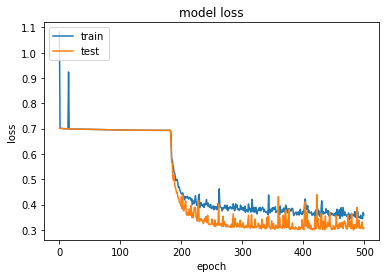

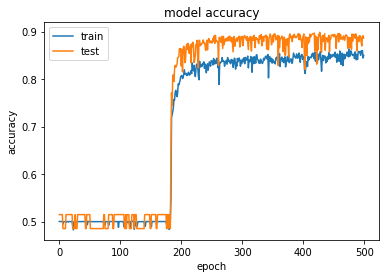

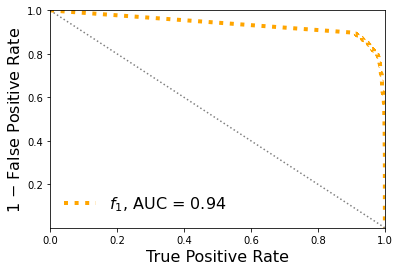

Classification score:


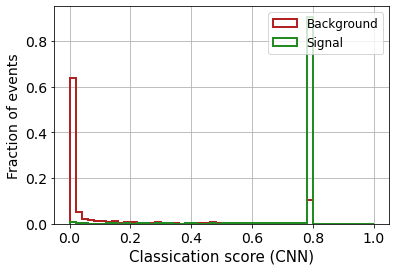


 ROC-AUC =  0.9358909016565741


In [92]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
#model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
#model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [93]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9358909016565741
